# Nonlinear Langevin with Double-Welled Potential

Here we take for out potential the function $$V(x) = 1/4(x^2-1)^2$$ and so the (overdamped, stochastic) Langenvin equation is $$dX_t = -V'(X_t)dt + \sigma dW_t = -X_t(X_t^2-1) + \sigma dW_t$$
We solve this numerically in various ways to get an approximate solution if to the equation. For instance we will often use Euler-Maruyama which soluction takes the form 
$$Y_{n+1} = Y_{n} + \Delta t\big(-Y_n(Y_n^2-1)\big) + \sigma \sqrt{\Delta t}v_n$$
where $Y_n \approx X_{\Delta t n}$ and $v_n \sim N(0,1)$ for all $n = 0,1,2,\dots$ are i.i.d.

The goal here is to reproduce the statisical and dynamical information (?). Of a realization of $Y = (Y_n;\;n=o,1,2,\dots)$ using a reduced model. We will compare the autocavariances as well as the pdf the $Y_n$. 

So, first we run the full model. To do this I use the function `DataGen_DWOL` found in th file `DataGen.jl` found in the current folder (`Examples\Nonlinear Langevin`).

In [1]:
using Plots
pyplot()

include("DataGen.jl") # This has many packages in it's preamble
include("../../Tools/Model_Reduction_Dev.jl")

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


vector_wiener_filter_fft

In [2]:
steps = 10^6 + 1
scheme = "FE"
t_start = 0
t_stop = 10^3
discard = 100000
sig_init = [1.5]
sigma = [.3]
V_prime = x -> -x.*(x.^2 .- 1)
SM1 = false
Obs_noise = false
d = 1
e = randn(d,steps + discard)


Y = DataGen_DWOL(
    steps;
    scheme, t_start, t_stop, discard, 
    sig_init , sigma, V_prime,
    SM1, Obs_noise, d, e
    )

T = range(t_start,stop = t_stop, length = steps)

0.0:0.001:1000.0

In [3]:
Psi(x) = [x; x.^3]

h_wf, pred = get_wf(Y,Psi, Preds = true);

Number of CKMS iterations: 3651
errK errR : 8.749524406347173e-11 3.909164997582715e-16


In [4]:
h_wf

1×2×20 Array{Float64,3}:
[:, :, 1] =
 -151.663  45.9847

[:, :, 2] =
 5.91944  -1.80656

[:, :, 3] =
 5.39593  -1.5999

...

[:, :, 18] =
 3.66798  -1.10736

[:, :, 19] =
 4.09605  -1.21659

[:, :, 20] =
 3.929  -1.18075

In [ ]:
Analytic WF

In [4]:
Δt = (t_stop - t_start)/(steps - 1)
h_ana = zeros(1,2,10)
h_ana[:,:,1] = [1+Δt -Δt]

1×2 Array{Float64,2}:
 1.001  -0.001

### Get `Y_hat` the One-Step Predictions

In [5]:
M_h = size(h_ana,3)

Y_hat = zeros(size(Y)); 
Y_hat[:,1:M_h] = Y[:,1:M_h]
for i=M_h:steps-1
    Y_hat[:,i] = sum(h_ana[:,:,k+1]*pred[:,i-k]
                    for k = 0:M_h-1)
end

In [7]:
err = Y - Y_hat

Lags = -100:10
C1 = my_crosscov(pred[1,:],err[:],Lags)
C2 = my_crosscov(pred[2,:],err[:],Lags)


111-element Array{Complex,1}:
 0.00010082107980577497 + 0.0im
  0.0001010241333077838 + 0.0im
  0.0001012275778214079 + 0.0im
 0.00010143145061237064 + 0.0im
 0.00010163662858327693 + 0.0im
  0.0001018431736264247 + 0.0im
 0.00010205083259621735 + 0.0im
 0.00010225928512282375 + 0.0im
  0.0001024689132575123 + 0.0im
 0.00010267861973464625 + 0.0im
   0.000102889136503843 + 0.0im
 0.00010309984359956733 + 0.0im
 0.00010331072475565378 + 0.0im
                        ⋮
  0.0001242887499949173 + 0.0im
 0.00012456001494777946 + 0.0im
 0.00012428852642394145 + 0.0im
 0.00012401818823131518 + 0.0im
 0.00012374754471645703 + 0.0im
  0.0001234774374523211 + 0.0im
 0.00012320774393827179 + 0.0im
 0.00012293917617875005 + 0.0im
 0.00012267064657969583 + 0.0im
  0.0001224029078254196 + 0.0im
 0.00012213597758312014 + 0.0im
 0.00012187037287046833 + 0.0im

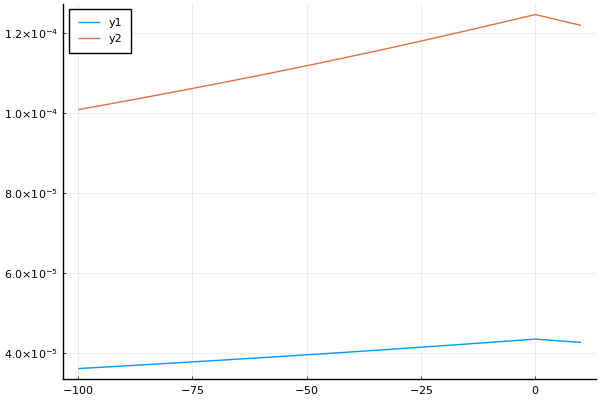

In [10]:
plot(Lags,real([C1 C2]))